# AIN311 TERM PROJECT - b2210765024 - İlbey GÜLMEZ

Either T ,AH, CO(GT) columns can be chosen as target features. But AH column is mainly treated like target feature in this assignment.

## Loading and shaping the Dataset

Import necessary libraries

In [65]:
pip install ucimlrepo  #Library to fetch dataset directly from the link

In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from ucimlrepo import fetch_ucirepo

In [67]:
# fetch dataset
air_quality = fetch_ucirepo(id=360)

In [68]:
# data (as pandas dataframes)
data = air_quality.data.features

In [69]:
data.shape #Before dropna

(9357, 15)

## Data Preprocessing

Check for missing values - no NaN values

In [70]:
data = data[data != ""]
data = data.dropna()

In [71]:
data.shape #After dropna, no NaN values

(9357, 15)

### Handle erroneous data

#### 'RH' (Relative Humidity)

In RH column;

The values should be in range 0-101 because it's represented with %.

Replace the invalid values with the mean of 'RH' data.

In [72]:
out_of_bounds = (data['RH'] < 0) | (data['RH'] > 100) # Determine the RH values that not in range  0 <= value <= 100

data.loc[out_of_bounds,'RH'] = np.nan # Set that values NaN

data['RH'] = data['RH'].fillna(data['RH'].mean()) # Fill the NaN values with the mean of the data (we can change the filling technique)

#### Other columns

Remaining columns (except 'T' - which will be inspected later on-) should be positive since they represent an amount.

Invalid values are replaced with the mean of corresponding columns.

In [73]:
remaining_columns = ['AH','CO(GT)','PT08.S1(CO)','NMHC(GT)','C6H6(GT)','PT08.S2(NMHC)','NOx(GT)','PT08.S3(NOx)','NO2(GT)','PT08.S4(NO2)','PT08.S5(O3)']

for column in remaining_columns:
    data.loc[data[column] < 0,column] = np.nan # Set -200 values to NaN
    data[column] = data[column].fillna(data[column].median()) # Fill them with median

### Visualize the data, detect and handle outliers

In [74]:
numeric_columns = data.columns[2:]
for column in numeric_columns:
    print(f"The maximum value in {column} : " ,data[column].max())
    print(f"The mean of {column} : " ,data[column].mean())
    print(f"The minimum value in {column} : " ,data[column].min())
    print()

The maximum value in CO(GT) :  11.9
The mean of CO(GT) :  2.0893021267500265
The minimum value in CO(GT) :  0.1

The maximum value in PT08.S1(CO) :  2040.0
The mean of PT08.S1(CO) :  1098.3924334722667
The minimum value in PT08.S1(CO) :  647.0

The maximum value in NMHC(GT) :  1189.0
The mean of NMHC(GT) :  156.72159880303516
The minimum value in NMHC(GT) :  7.0

The maximum value in C6H6(GT) :  63.7
The mean of C6H6(GT) :  10.009447472480497
The minimum value in C6H6(GT) :  0.1

The maximum value in PT08.S2(NMHC) :  2214.0
The mean of PT08.S2(NMHC) :  937.973923266004
The minimum value in PT08.S2(NMHC) :  383.0

The maximum value in NOx(GT) :  1479.0
The mean of NOx(GT) :  235.17890349470983
The minimum value in NOx(GT) :  2.0

The maximum value in PT08.S3(NOx) :  2683.0
The mean of PT08.S3(NOx) :  834.3399593886929
The minimum value in PT08.S3(NOx) :  322.0

The maximum value in NO2(GT) :  340.0
The mean of NO2(GT) :  112.37330340921235
The minimum value in NO2(GT) :  2.0

The maximu

Define a function that plots the given data's distribution:

In [75]:
def plot_feature_distributions(data, columns):
    plt.figure(figsize=(15, 12))
    for i, column in enumerate(columns):
        plt.subplot(3, 4, i+1)  # Create subplots
        sns.histplot(data[column], bins=20, kde=True)
        plt.title(column)
    plt.tight_layout()
    plt.show()

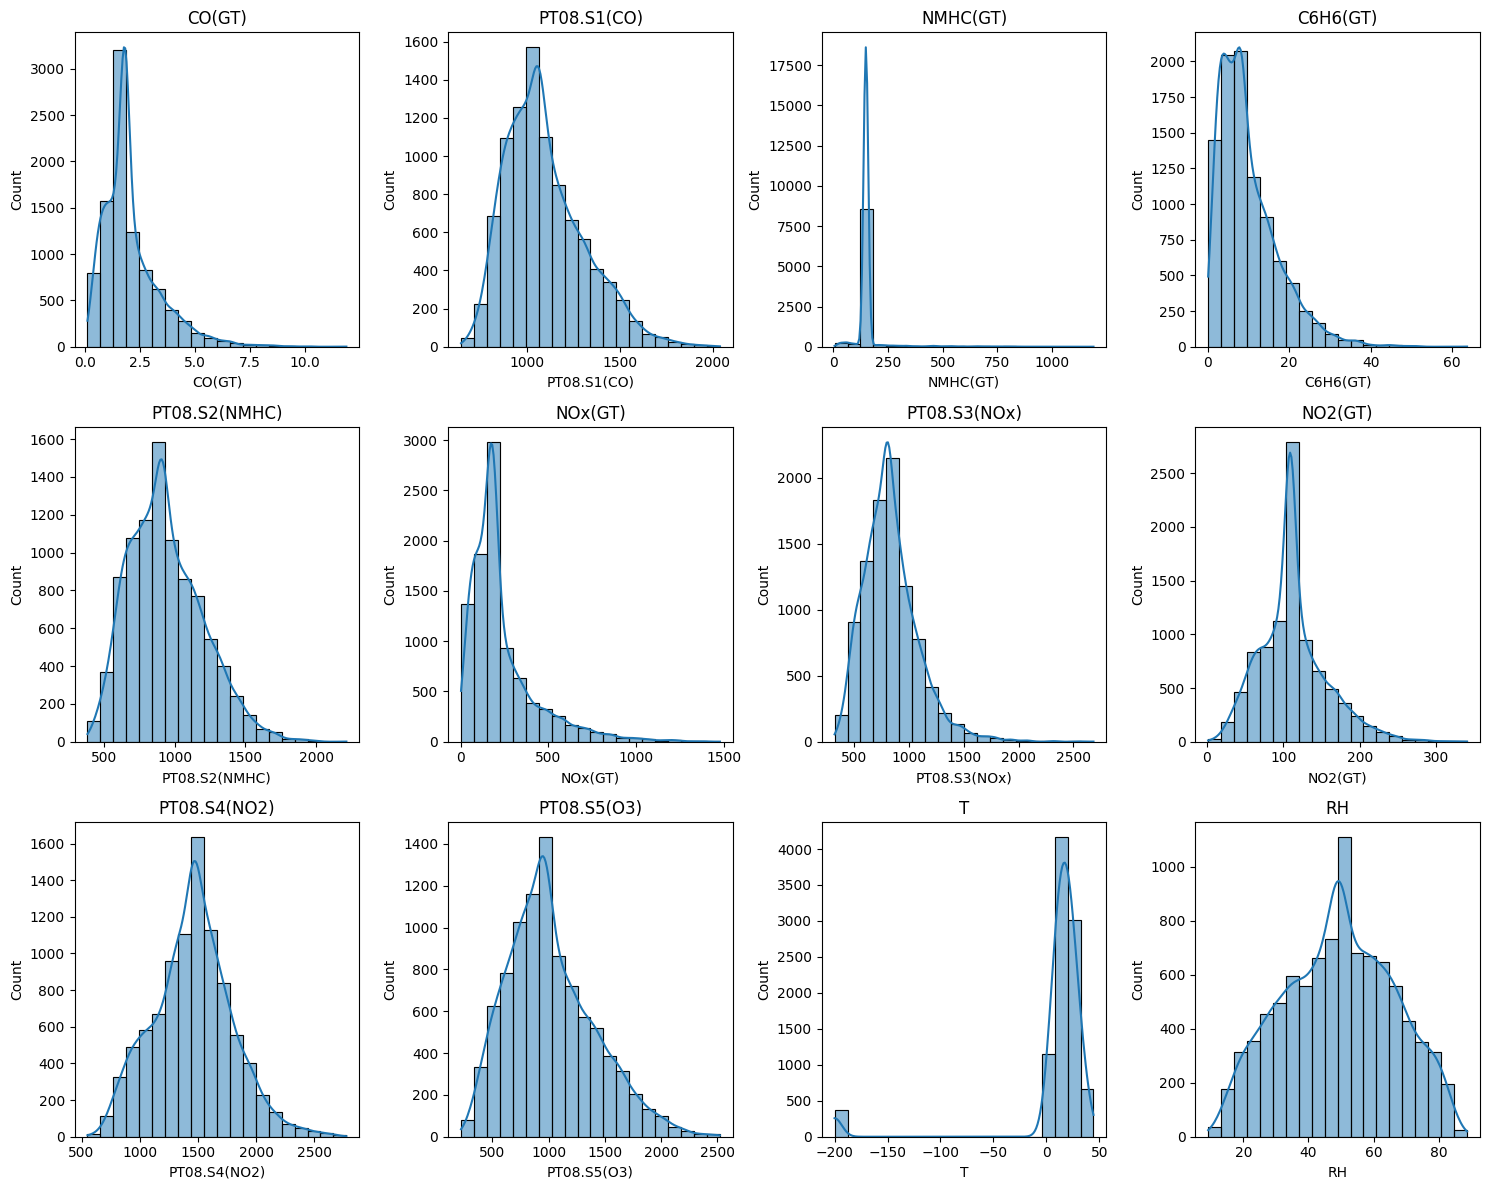

In [76]:
plot_feature_distributions(data, numeric_columns[:-1])

From the histograms above, it can be concluded that data is very noisy.

-CO(GT) data is right skewed. Meaning the outliers tend to be higher rather than lower. Also, mean is bigger than the median.

-PT08 S1(CO) data is right skewed with the longest tail and its closer to normal distribution than CO(GT).

-NMHC(GT) data has a small range of data with high frequencies focused between 230-250. Assigning smaller weight to this would make model perform better if these aren't strongly correlated with target feature.

-C6H6(GT) is also right skewed and its further to normal distribution than others.

-PT08 S2(NMHC) data is almost similar to PT08 S1(CO) data. So dimension reduction techniques can be applied.

-NOx(GT) data is also right skewed.

-PT08 S3(NOx) data has a shorter tail compared to other PT08 measurements.

-NO2(GT) data is slightly right skewed, making it closer to the normal distribution. Data has high frequency between 100-120.

-PT08 S4(NO2) data can be interpreted as the smoother version of NO2(GT)

-PT08 S5(O3) data is slighty right skewed and has less noise then NO2(GT)

-T data has erroneous values at -200 and they will be handled.

-RH data is normally distributed with data focused in 48-52 bins.

Summary, it can be concluded that the data is very noisy, has outliers and erroneous inputs.

Consequantially, calculating IQR and handling the values that falls over 1.5 * IQR of third quantile or below -1.5 * IQR of first quantile will make them smoother and features will contribute to possible model's performance.

NOTE : Histograms are going to be evaluated one more time after outlier handling.

In [77]:
for column in numeric_columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - (1.5 * IQR)
    upper_bound = Q3 + (1.5 * IQR)
    bound_condition = (data[column] < lower_bound) | (data[column] > upper_bound)
    data.loc[bound_condition,column] = np.nan
    data[column] = data[column].fillna(data[column].mean())

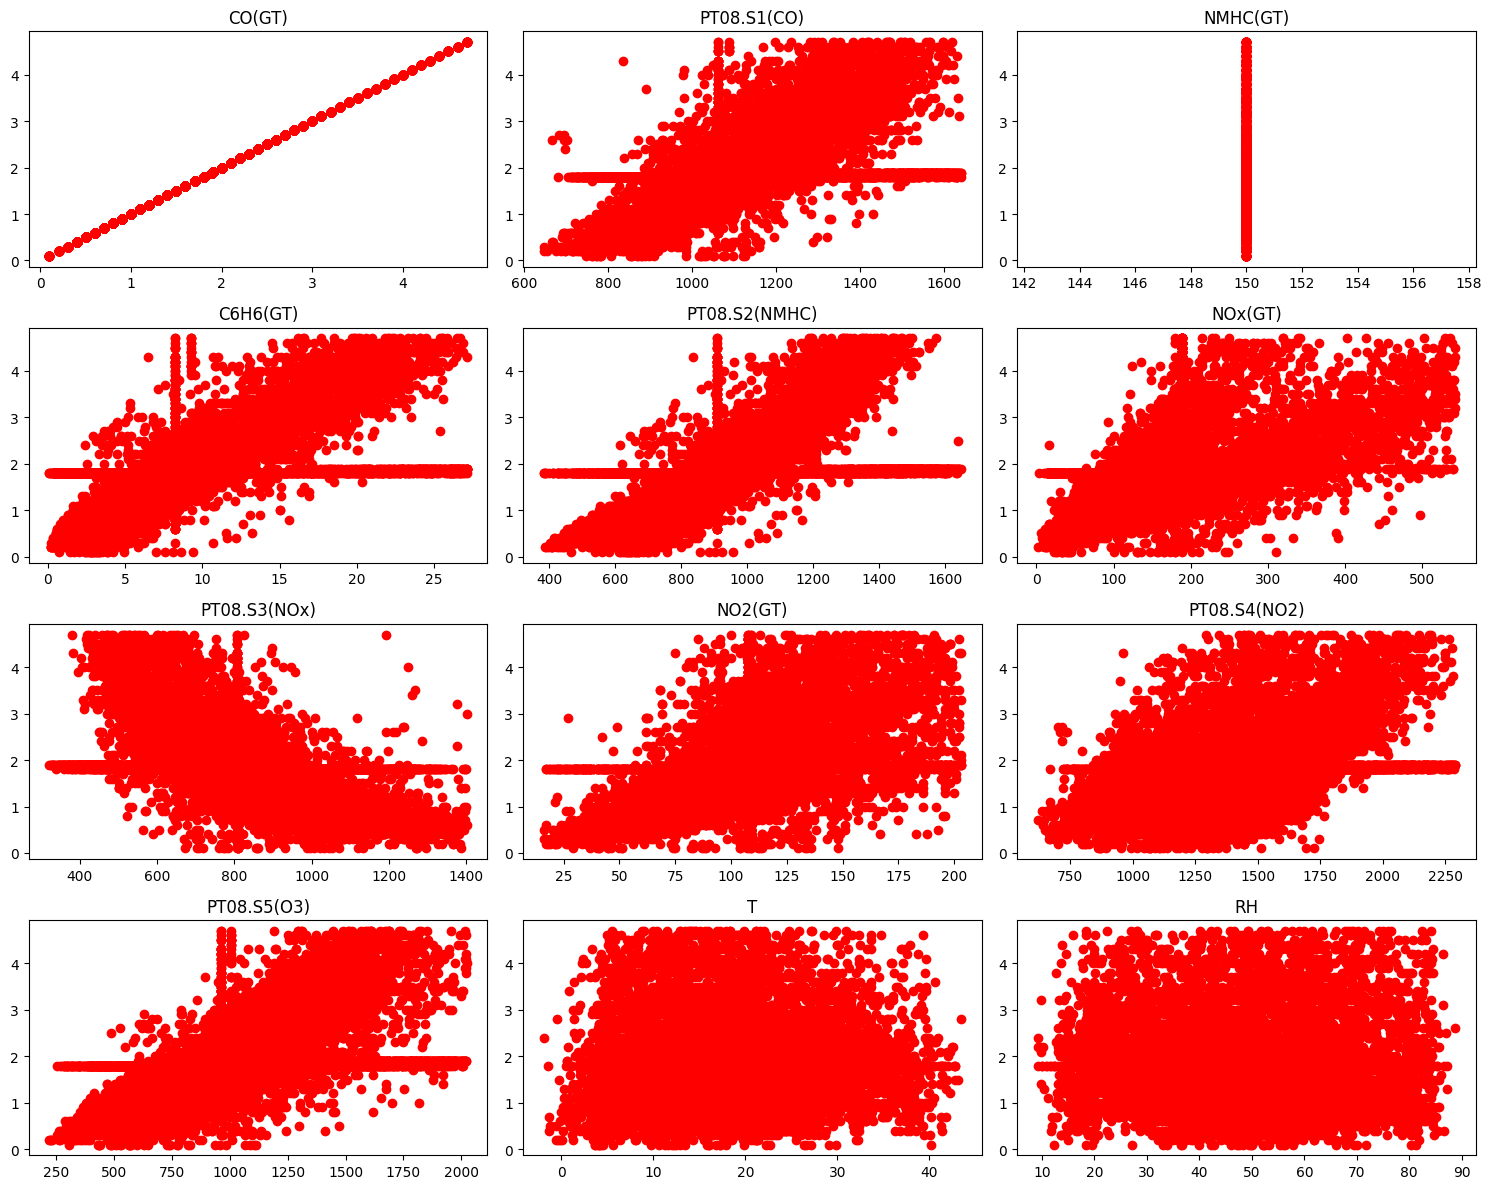

In [78]:
plt.figure(figsize=(15, 12))
for i, column in enumerate(numeric_columns[:-1]):
    plt.subplot(4, 3, i + 1)
    plt.scatter(data[column], data['CO(GT)'],color = 'Red')
    plt.title(column)
plt.tight_layout()
plt.show()

CO(GT) seems to be positively correlated with almost all features except T,RH and AH so these will be dropped.

NMHC(GT) column seems to be an unstable column, it will be dropped

Date and Time columns will be used in further inspection, for first model trials, they will be dropped too.

In [79]:
data = data.drop(['T','RH','AH','NMHC(GT)','Date','Time'], axis = 1)

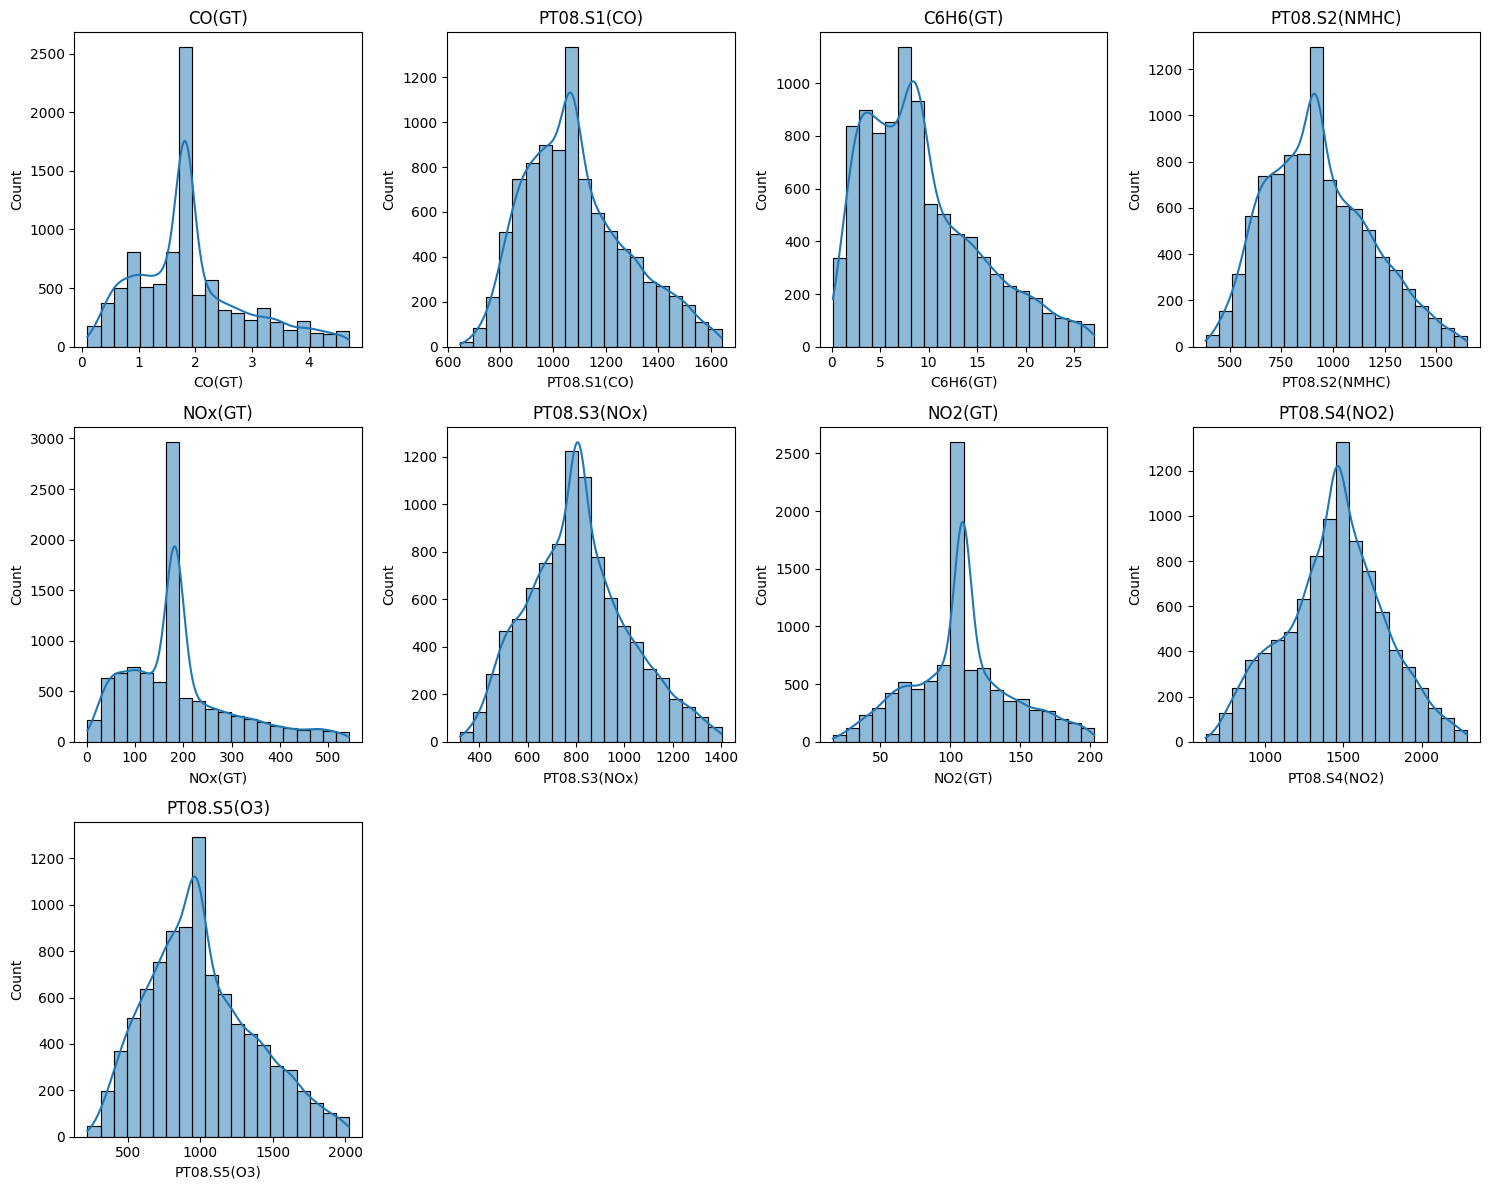

In [80]:
plot_feature_distributions(data, data.columns)

In [81]:
data

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3)
0,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0
1,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0
2,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0
3,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0
4,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0
...,...,...,...,...,...,...,...,...,...
9352,3.1,1314.0,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0
9353,2.4,1163.0,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0
9354,2.4,1142.0,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0
9355,2.1,1003.0,9.5,961.0,235.0,702.0,156.0,1041.0,770.0


After outlier handling, skewness of the distributions are reduced and they are all closer to normal distribution.

(Note that erroneous values in T column are eliminated too while detecting outliers.)

In this stage, the data is more refined and ready to be scaled.

## Step 3: Data Transformation

Apply Z - Score Normalization to scale the value.

I didn't use Min-Max scaling because data is very noisy.

In [82]:
scaler = StandardScaler()
cols = data.columns
data = scaler.fit_transform(data)

In [83]:
sc_data = pd.DataFrame(data, columns = cols)

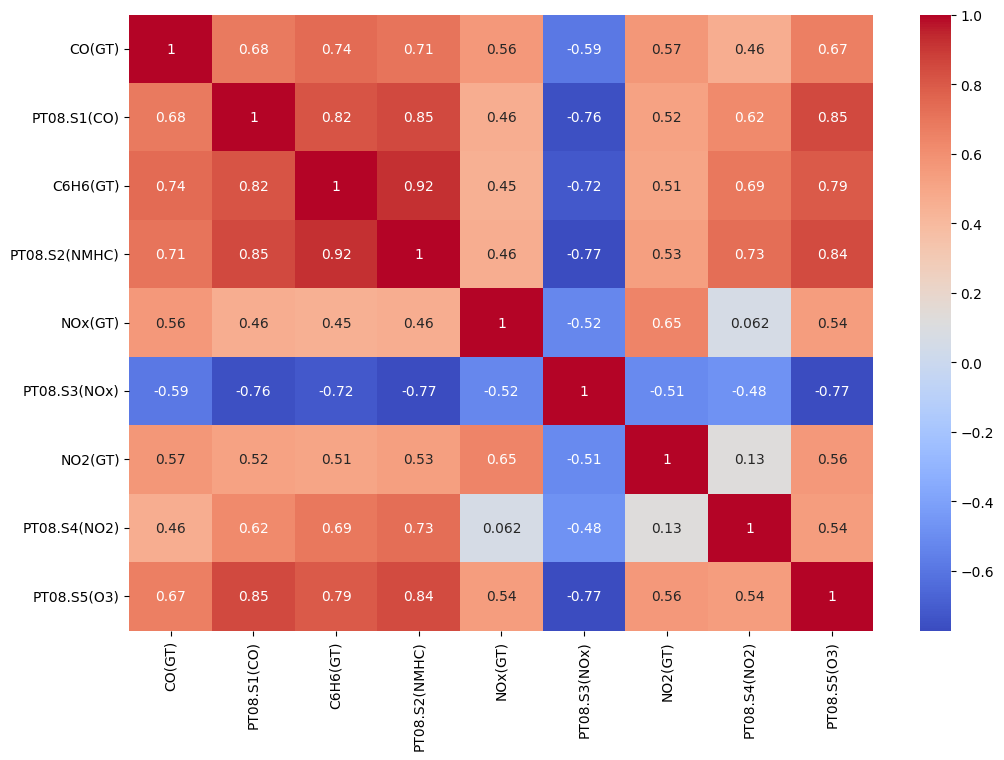

In [84]:
correlation_matrix = sc_data.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

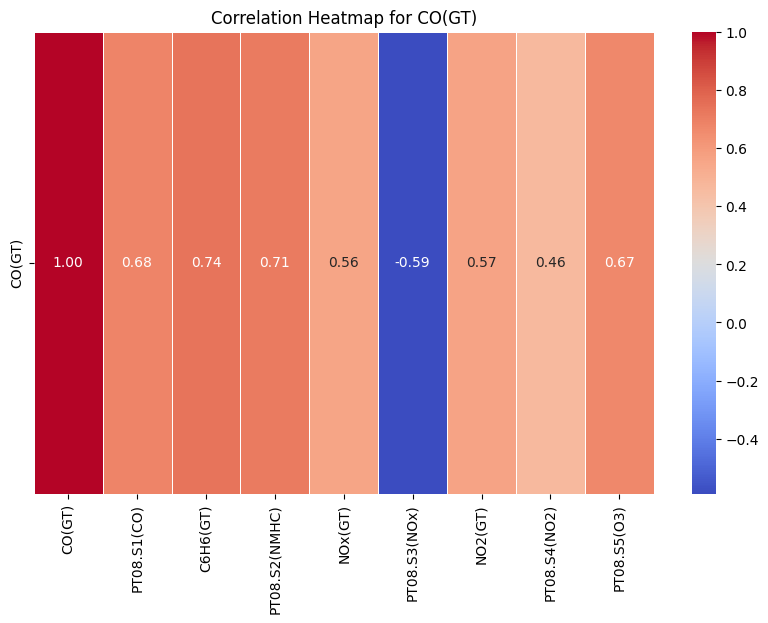

In [85]:
correlation_matrix = sc_data.corr()
correlation_with_target = correlation_matrix["CO(GT)"]
# Reshape the correlation values to a DataFrame for heatmap
correlation_df = correlation_with_target.to_frame().T

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap for CO(GT)')
plt.show()

Divide the data into 2 sections, GT and PT08 abd train_test_split them.

In [86]:
def evaluate(actual,predicted,model,data):
  mae= mean_absolute_error(actual, predicted)
  mse = mean_squared_error(actual, predicted)
  r2 = r2_score(actual, predicted)

  print(f"MAE of {model} with {data} is:  {mae}")
  print(f"MSE of {model} with {data} is:  {mse}")
  print(f"R2 Score of {model} with {data} is:  {r2}")
  print()


In [98]:
def plot_x_and_y(x_values, y_values, title, y_label, x_label):
  # Plotting
  plt.plot(x_values, y_values, marker='o', linestyle='-', color='b', label='Data Points')

  # Adding labels and title
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  # Adding legend
  plt.legend()

  # Display the plot
  plt.show()

In [88]:
GT_data = sc_data.drop(['PT08.S1(CO)','PT08.S2(NMHC)','PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)','CO(GT)'], axis = 1)
PT08_data = sc_data.drop(GT_data, axis = 1)
PT08_data = PT08_data.drop('CO(GT)', axis = 1)

In [89]:
GT_train, GT_test, y_train_GT, y_test_GT = train_test_split(GT_data, sc_data['CO(GT)'], test_size=0.33, random_state=42)

In [90]:
PT08_train, PT08_test, y_train_PT, y_test_PT = train_test_split(PT08_data, sc_data['CO(GT)'], test_size=0.33, random_state=31)

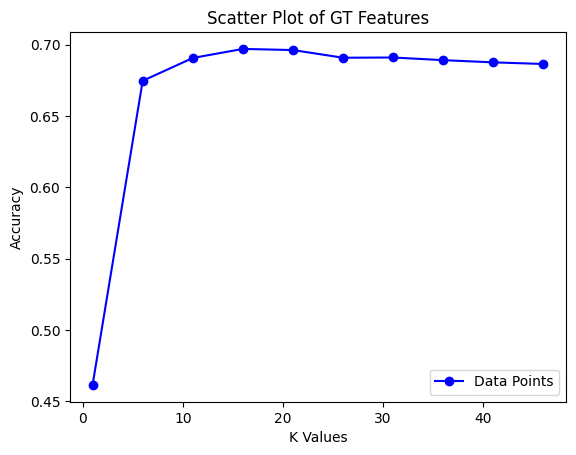

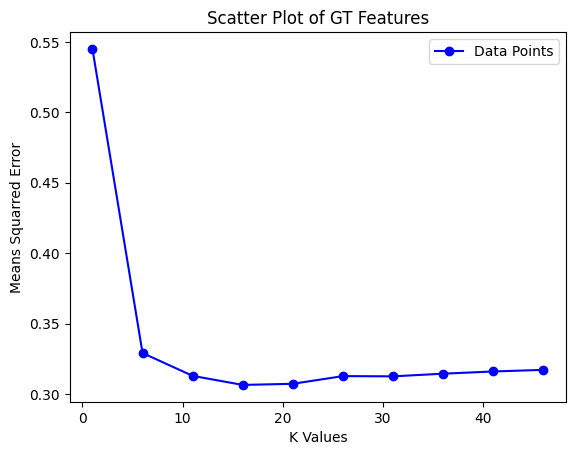

In [99]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []

for k in k_values:
  model_knn_GT = KNeighborsRegressor(n_neighbors=k)

  knn_GT = model_knn_GT.fit(GT_train, y_train_GT)
  predicted_knn_GT = model_knn_GT.predict(GT_test)
  accuracies.append(knn_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_knn_GT.predict(GT_test))
  error.append(mse)


plot_x_and_y(k_values,accuracies,"Scatter Plot of GT Features", "Accuracy","K Values")
plot_x_and_y(k_values,error,"Scatter Plot of GT Features", "Means Squarred Error", "K Values")


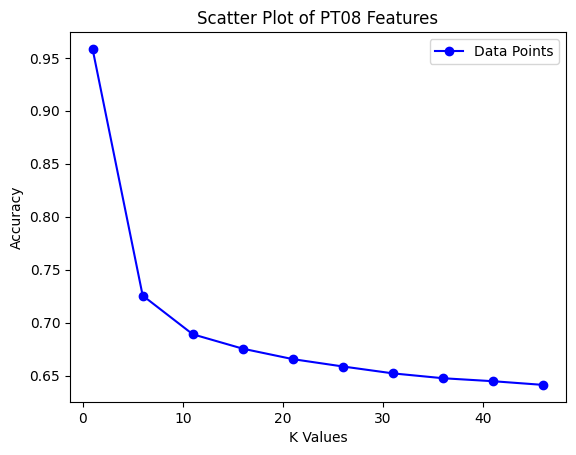

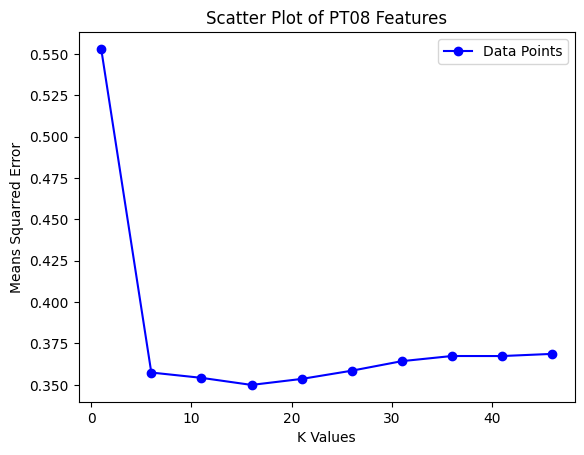

In [100]:
# Fit kNN to the datasets
k_values = range(1,51,5)
accuracies = []
error = []

for k in k_values:
  model_knn_PT = KNeighborsRegressor(n_neighbors=k)

  knn_PT = model_knn_PT.fit(PT08_train, y_train_PT)

  accuracies.append(knn_PT.score(PT08_train, y_train_PT))

  mse = mean_squared_error(y_test_PT, knn_PT.predict(PT08_test))
  error.append(mse)


plot_x_and_y(k_values,accuracies,"Scatter Plot of PT08 Features", "Accuracy", "K Values")
plot_x_and_y(k_values,error,"Scatter Plot of PT08 Features", "Means Squarred Error","K Values")


In [101]:
# Fit Linear Regression to the datasets
model_reg_GT = LinearRegression()
model_reg_PT = LinearRegression()

reg_GT = model_reg_GT.fit(GT_train, y_train_GT)

print(f"Accuracy of Linear Regression with GT is: {reg_GT.score(GT_test, y_test_GT)}")
print(f"MSE of Linear Regression with GT is: {mean_squared_error(y_test_GT, reg_GT.predict(GT_test))}\n")

reg_PT = model_reg_PT.fit(PT08_train, y_train_PT)
print(f"Accuracy of Linear Regression with PT08 is: {reg_PT.score(PT08_test, y_test_PT)}")
print(f"MSE of Linear Regression with PT08 is: { mean_squared_error(y_test_PT, reg_PT.predict(PT08_test))}")


Accuracy of Linear Regression with GT is: 0.6282987135236088
MSE of Linear Regression with GT is: 0.37609044535029634

Accuracy of Linear Regression with PT08 is: 0.5249464214404909
MSE of Linear Regression with PT08 is: 0.45515681937198793


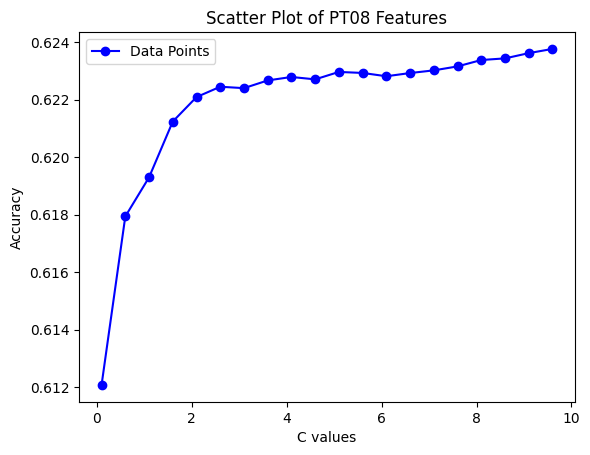

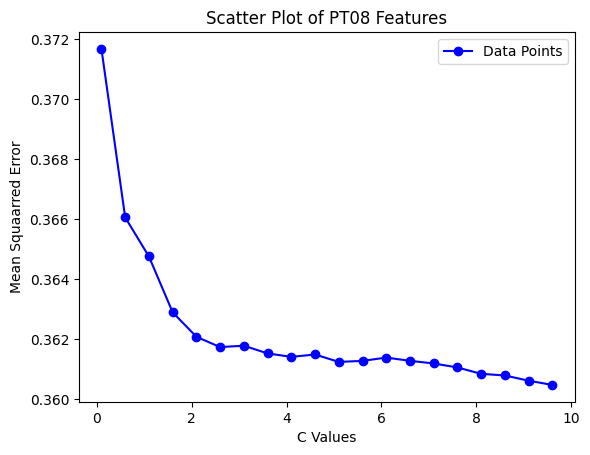

In [102]:
# Fit SVR to the dataset

C_values = [x / 10 for x in range(1,100,5)]
accuracies = []
error = []

for c in C_values:


  model_svr_PT = make_pipeline(StandardScaler(), SVR(C=c, epsilon=0.2))
  svr_PT = model_svr_PT.fit(PT08_train, y_train_PT)
  accuracies.append(svr_PT.score(PT08_test, y_test_PT))

  mse = mean_squared_error(y_test_PT, model_svr_PT.predict(PT08_test))

  error.append(mse)

plot_x_and_y(C_values,accuracies,"Scatter Plot of PT08 Features", "Accuracy", "C values")
plot_x_and_y(C_values,error,"Scatter Plot of PT08 Features", "Mean Squaarred Error","C Values")



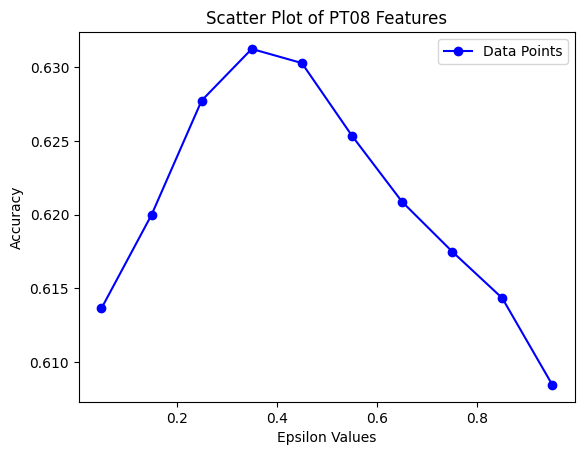

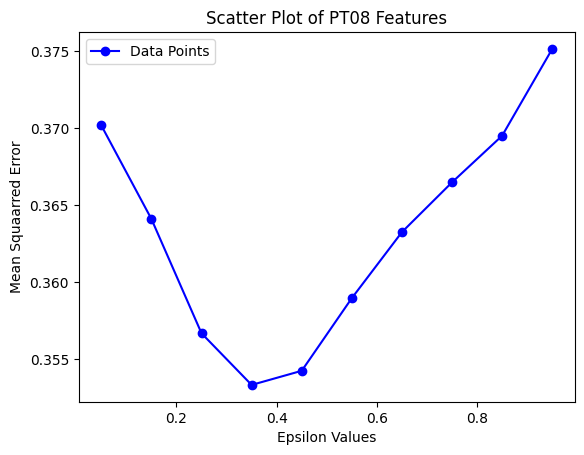

In [103]:
# Fit SVR to the dataset

epsilon_values = [x / 20 for x in range(1,20,2)]
accuracies = []
error = []

for e in epsilon_values:


  model_svr_PT = make_pipeline(StandardScaler(), SVR(C=c, epsilon=e))
  svr_PT = model_svr_PT.fit(PT08_train, y_train_PT)
  accuracies.append(svr_PT.score(PT08_test, y_test_PT))

  mse = mean_squared_error(y_test_PT, model_svr_PT.predict(PT08_test))

  error.append(mse)

plot_x_and_y(epsilon_values,accuracies,"Scatter Plot of PT08 Features", "Accuracy","Epsilon Values")
plot_x_and_y(epsilon_values,error,"Scatter Plot of PT08 Features", "Mean Squaarred Error","Epsilon Values")



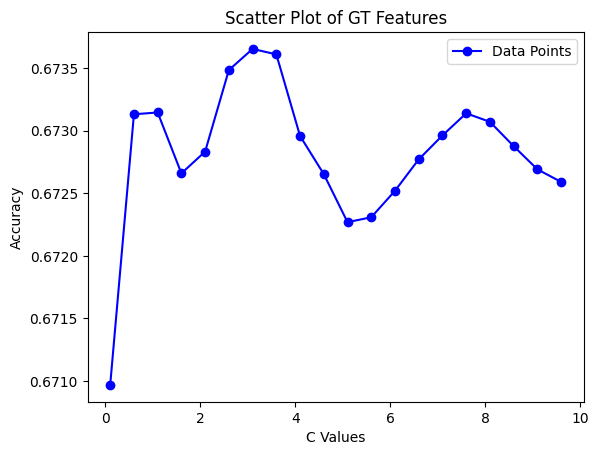

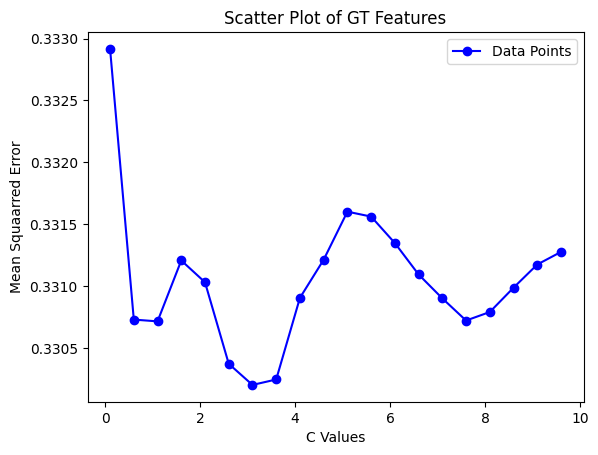

In [104]:
# Fit SVR to the dataset

C_values = [x / 10 for x in range(1,100,5)]
accuracies = []
error = []

for c in C_values:


  model_svr_GT = make_pipeline(StandardScaler(), SVR(C=c, epsilon=0.2))
  svr_GT = model_svr_GT.fit(GT_train, y_train_GT)
  accuracies.append(svr_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_svr_GT.predict(GT_test))

  error.append(mse)

plot_x_and_y(C_values,accuracies,"Scatter Plot of GT Features", "Accuracy","C Values")
plot_x_and_y(C_values,error,"Scatter Plot of GT Features", "Mean Squaarred Error","C Values")



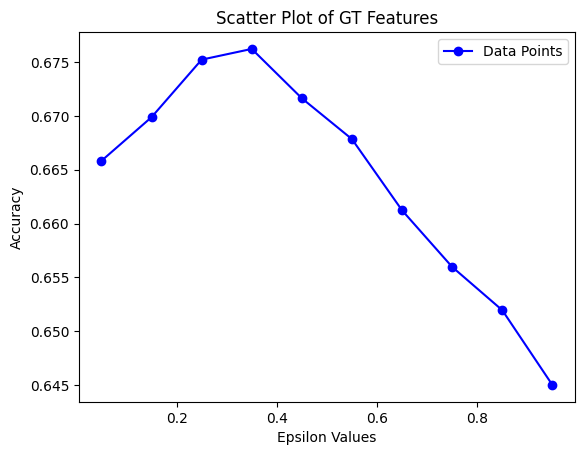

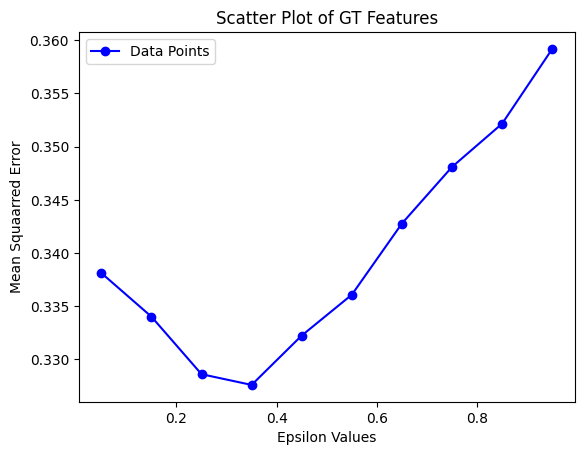

In [105]:
# Fit SVR to the dataset

epsilon_values = [x / 20 for x in range(1,20,2)]
accuracies = []
error = []

for e in epsilon_values:


  model_svr_GT = make_pipeline(StandardScaler(), SVR(C=c, epsilon=e))
  svr_GT = model_svr_GT.fit(GT_train, y_train_GT)
  accuracies.append(svr_GT.score(GT_test, y_test_GT))

  mse = mean_squared_error(y_test_GT, model_svr_GT.predict(GT_test))

  error.append(mse)

plot_x_and_y(epsilon_values,accuracies,"Scatter Plot of GT Features", "Accuracy","Epsilon Values")
plot_x_and_y(epsilon_values,error,"Scatter Plot of GT Features", "Mean Squaarred Error","Epsilon Values")

